In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
from scipy.stats import chi2_contingency


# 1. Data preparation

In [16]:
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

In [17]:
df_initial.shape

(541909, 8)

In [18]:
df_initial.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [19]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [20]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [21]:
df_initial.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [22]:
# gives some infos on columns types and numer of null values

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


- While looking at the number of null values in the dataframe, it is interesting to note that  ∼ 25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:

In [23]:
df_initial.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [12]:
df_initial.dropna(axis=0, subset=['CustomerID'], inplace =True)

In [13]:
df_initial.shape

(406829, 8)

In [14]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


# 2. Exploring the content of variables

- This dataframe contains 8 variables that correspond to:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 4

Description: Product (item) name. Nominal. 

Quantity: The quantities of each product (item) per transaction. Numeric. 

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 

UnitPrice: Unit price. Numeric, Product price per unit in sterling. 

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 

Country: Country name. Nominal, the name of the country where each customer resides.



### 2.1 Countries

In [7]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp.head()

Empty DataFrame
Columns: []
Index: [(12346, 541431, United Kingdom), (12346, C541433, United Kingdom), (12347, 537626, Iceland), (12347, 542237, Iceland), (12347, 549222, Iceland)]

In [8]:
temp = temp.reset_index(drop=False)


In [9]:
temp.head()

,CustomerID,InvoiceNo,Country
0,12346,541431,United Kingdom
1,12346,C541433,United Kingdom
2,12347,537626,Iceland
3,12347,542237,Iceland
4,12347,549222,Iceland


In [10]:
countries = temp['Country'].value_counts()
countries.head()

United Kingdom    19857
Germany             603
France              458
EIRE                319
Belgium             119
Name: Country, dtype: int64

In [11]:
len(countries)

37

#### Result on a chloropleth map:

In [12]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

- We see that the dataset is largely dominated by orders made from the UK.

### 2.2 Customers and products

In [14]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [15]:
df_initial.shape

(541909, 8)

In [24]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null object
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [25]:
# The dataframe contains  ∼ 400,000 entries. What are the number of users and products in these entries ?
customer = df_initial['CustomerID'].drop_duplicates()

In [26]:
len(customer)

4372

In [27]:
df_initial.CustomerID.nunique()

4372

In [28]:
df_initial.InvoiceNo.nunique()

22190

In [29]:
df_initial.StockCode.nunique()

3684

In [30]:
df_initial.CustomerID.value_counts().head()

17841    7983
14911    5903
14096    5128
12748    4642
14606    2782
Name: CustomerID, dtype: int64

In [31]:
pd.DataFrame([{'products':df_initial.StockCode.nunique() ,    
               'transactions': df_initial.InvoiceNo.nunique(),
               'customers': df_initial.CustomerID.nunique(),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


- It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of  ∼ 22'000.

Now I will determine the number of products purchased in every transaction:

In [32]:
temp.head()

,CustomerID,InvoiceNo,Country
0,12346,541431,United Kingdom
1,12346,C541433,United Kingdom
2,12347,537626,Iceland
3,12347,542237,Iceland
4,12347,549222,Iceland


In [33]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [34]:
temp = df_initial.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
temp.head()

,CustomerID,InvoiceNo,InvoiceDate
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [35]:
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [37]:
nb_products_per_basket[nb_products_per_basket['CustomerID']=='17850'].head()

,CustomerID,InvoiceNo,Number of products
20683,17850,536365,7
20684,17850,536366,2
20685,17850,536372,2
20686,17850,536373,16
20687,17850,536375,16


In [38]:
df_initial[df_initial['CustomerID']=='12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


In [39]:
df_initial[df_initial['CustomerID']=='17850'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [40]:
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


- The first lines of this list shows several things worthy of interest:


the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled

the existence of users who only came once and only purchased one product (e.g. nº12346)

the existence of frequent users that buy a large number of items at each order

### 2.2.1 Cancelling orders

- First of all, I count the number of transactions corresponding to canceled orders:

In [41]:
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [42]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [43]:
n1 = nb_products_per_basket['order_canceled'].sum()
n1

3654

In [44]:
n2 = nb_products_per_basket.shape[0]
n2

22190

In [45]:
nb_products_per_basket.shape

(22190, 4)

In [48]:
8/16

0.5

In [47]:
from __future__ import division

In [49]:
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

In [50]:
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


- We note that the number of cancellations is quite large ( ∼ 16% of the total number of transactions). Now, let's look at the first lines of the dataframe:



### next step)

In [51]:
df_initial.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347,Iceland


- On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables. I decide to check if this is true for all the entries. To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice):

In [52]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity', 'StockCode','Description','UnitPrice']]
df_check.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527,-1,D,Discount,27.50
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29


In [53]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [78]:
df_initial['CustomerID'].shape[0]

406829L

In [90]:
df_custom = df_initial[df_initial['CustomerID']=='14527']
df_custom.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


In [94]:
df_custom[df_custom['InvoiceNo']=='C536379']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5,14527,United Kingdom


In [98]:
df_initial[df_initial['Description']=='Discount'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422,United Kingdom


In [75]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


- We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries:

In [55]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

(154L, CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object)
---------------> HYPOTHESIS NOT FULFILLED


- Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [99]:
df_initial.shape

(406829, 8)

In [106]:
df_check.shape[0]==0

False

In [104]:
df_initial[df_initial['StockCode']=='35004C']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431,Australia
297,536397,35004C,SET OF 3 COLOURED FLYING DUCKS,48,2010-12-01 10:51:00,4.65,17924,United Kingdom
2316,536576,35004C,SET OF 3 COLOURED FLYING DUCKS,120,2010-12-01 16:11:00,4.65,13777,United Kingdom
3933,536739,35004C,SET OF 3 COLOURED FLYING DUCKS,3,2010-12-02 13:08:00,5.45,14180,United Kingdom
6544,536947,35004C,SET OF 3 COLOURED FLYING DUCKS,3,2010-12-03 12:29:00,5.45,13013,United Kingdom
7417,537036,35004C,SET OF 3 COLOURED FLYING DUCKS,1,2010-12-03 17:28:00,5.45,15545,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
17311,537700,35004C,SET OF 3 COLOURED FLYING DUCKS,48,2010-12-08 10:51:00,4.65,18229,United Kingdom
17451,537762,35004C,SET OF 3 COLOURED FLYING DUCKS,3,2010-12-08 12:01:00,5.45,16558,United Kingdom


In [56]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

In [57]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [58]:
df_initial.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


### - In the above function, I checked the two cases:

a cancel order exists without counterpart
there's at least one counterpart with the exact same quantity
The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [59]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
     # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break  

In [60]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7543
doubtfull_entry: 1229


- Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries, which count respectively for ∼ 1.4% and 0.2% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

#### checking what is it

In [108]:
for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue     
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

KeyboardInterrupt: 

In [61]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries.heaf

nb of entries to delete: 56


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
58496,C541245,85036C,ROSE 1 WICK MORRIS BOXED CANDLE,-12,2011-01-16 12:40:00,4.25,15535,United Kingdom,0
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0


In [66]:
df_cleaned.shape

(398057, 9)

In [67]:
df_initial.shape

(406829, 8)

In [62]:
remaining_entries.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
58496,C541245,85036C,ROSE 1 WICK MORRIS BOXED CANDLE,-12,2011-01-16 12:40:00,4.25,15535,United Kingdom,0
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0


In [69]:
remaining_entries.shape

(56, 9)

In [70]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [71]:
df_cleaned.shape

(398001, 9)

- If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [72]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


- We see that the quantity canceled is greater than the sum of the previous purchases.

In [73]:
df_cleaned.to_csv('data_cleaned.csv')

### 2.2.2 StockCode

- Above, it has been seen that some values of the StockCode variable indicate a particular transaction (i.e. D for Discount). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [64]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array([u'POST', u'D', u'C2', u'M', u'BANK CHARGES', u'PADS', u'DOT'], dtype=object)

In [65]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


- We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

- These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database

In [109]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [110]:
df_cleaned.shape

(396370, 9)

#  Outliers

In [111]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,396370.000000,396370.000000,396370.000000
mean,13.046474,2.867983,0.618215
std,180.733597,4.264566,174.747506
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


#### The minimum value for the unitprice is 0, let's see why is that.

In [112]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0


##### I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that. Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values

### 2.2.3 Basket Price

- I create a new variable that indicates the total price of every purchase:

In [113]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [114]:
df_cleaned.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,0
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,0


In [115]:
df_cleaned['QuantityCanceled'].sum()

245042

In [117]:
df_cleaned[df_cleaned['QuantityCanceled']!=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100,United Kingdom,12
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom,2
98,536378,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,1
99,536378,84991,60 TEATIME FAIRY CAKE CASES,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,27
139,536381,22719,GUMBALL MONOCHROME COAT RACK,36,2010-12-01 09:41:00,1.06,15311,United Kingdom,3
211,536390,22941,CHRISTMAS LIGHTS 10 REINDEER,2,2010-12-01 10:19:00,8.50,17511,United Kingdom,1
212,536390,22960,JAM MAKING SET WITH JARS,12,2010-12-01 10:19:00,3.75,17511,United Kingdom,1
221,536390,22197,SMALL POPCORN HOLDER,100,2010-12-01 10:19:00,0.72,17511,United Kingdom,1
222,536390,22198,LARGE POPCORN HOLDER,50,2010-12-01 10:19:00,1.45,17511,United Kingdom,2
228,536390,22654,DELUXE SEWING KIT,40,2010-12-01 10:19:00,4.95,17511,United Kingdom,1


In [118]:
df_cleaned[(df_cleaned['CustomerID'] == '15311') & (df_cleaned['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom,1
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom,3
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom,0
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom,2


### I create a new variable that indicates the total price of every purchase:

In [121]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


In [125]:
df_cleaned.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
535014,581180,23508,MINI PLAYING CARDS DOLLY GIRL,20,2011-12-07 15:52:00,0.42,12347,Iceland,0,8.4
14946,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.0
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.0
14944,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.0


### Feature engineering

In [128]:
def unique_counts(data):
    for i in data.columns:
        count = data[i].nunique()
        print(i, ": ", count)
unique_counts(df_cleaned)

(u'InvoiceNo', ': ', 18405)
(u'StockCode', ': ', 3659)
(u'Description', ': ', 3871)
(u'Quantity', ': ', 300)
(u'InvoiceDate', ': ', 17169)
(u'UnitPrice', ': ', 356)
(u'CustomerID', ': ', 4335)
(u'Country', ': ', 37)
('QuantityCanceled', ': ', 122)
('TotalPrice', ': ', 3149)


In [127]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


In [129]:
df_cleaned.to_csv('df_w_cleaned.csv')

## We can now look at the countries' monetary value thanks to this feature

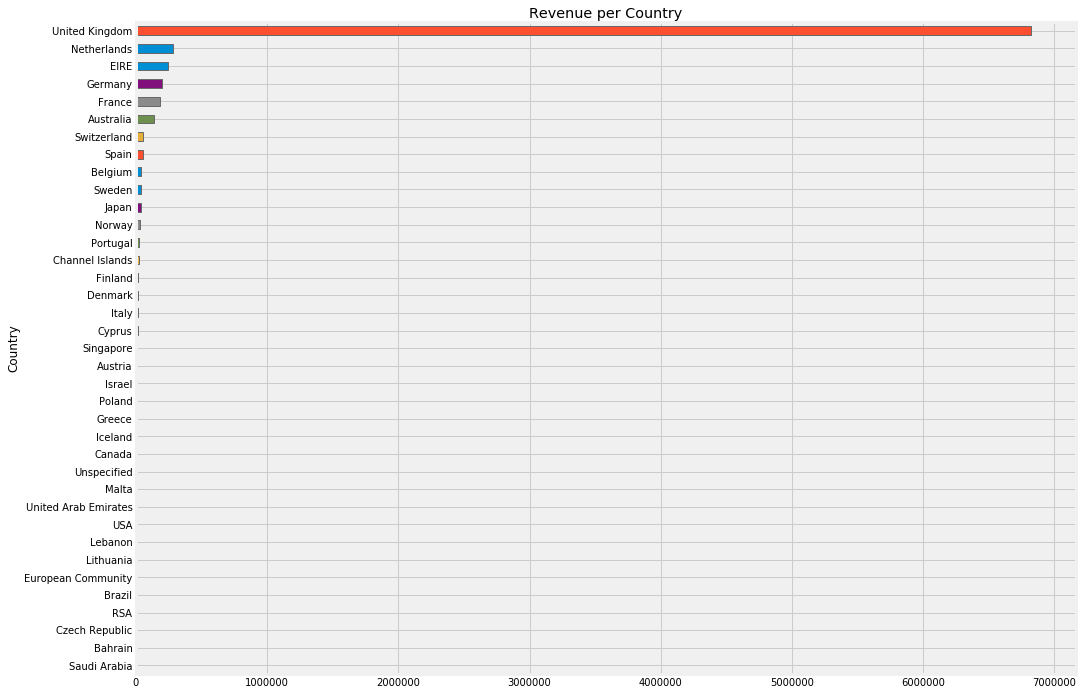

In [130]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

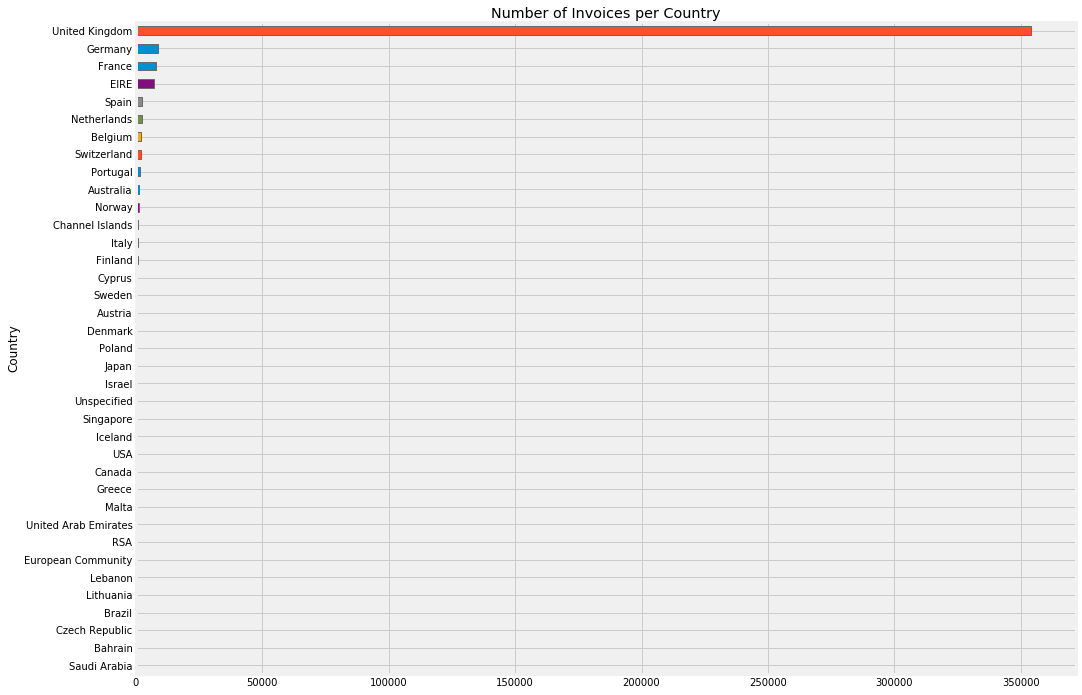

In [131]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

- This is very interesting since we can see that Netherlands is the 2nd country in value even though it has less invoices than countries like Germany or France for example and 10 times less customers. (95, 87 and 9 for Germany, France and Netherlands respectively)

# 3) 3. Insight on product categories

- In the dataframe, products are uniquely identified through the StockCode variable. A shrort description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.